# Machine Learning Model Construction for Single Cell RNA-Seq Clustering Parameter Evaluation Results

## Method

Tabula Muris Droplet, Tabula Muris Spike and Zhengmix datasets were downloaded using R/Bioconductor. Datasets are preprocessed using **scran**. For each dataset, *Shared Nearest Neighbour* based graph construction and graph clustering using 3 popular algorithms, Walktrap, Louvain and Leiden algorithms from **igraph** package.
SNN graphs for each dataset with *number of neighbours* parameter from 1 to 50, Highly Variant Genes as 500, 1000, 1500 and 2000 were constructed. *DenoisePCA* function from scran package is used for PCA. Adjusted Rand Index used for clustering comparison with cell labels. Clusterings with ARI higher than 0.65 are labelled as accepted.

### Applying Machine Learning Algorithms to build a model and show importances of parameters

#### Required Packages

In [1]:
import numpy as np
import pandas as pd

from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

import lightgbm
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from catboost import CatBoostClassifier, Pool

#### Data Import (Preprocessed using R)

In [4]:
encoded_results = pd.read_csv("encoded_dataset.txt" , sep = "\t")

In [5]:
encoded_results.head()

,Number_of_Neighbours,Number_of_PCs,Number_of_Cells,Number_of_HVGs,AlgorithmLeiden,AlgorithmLouvain,AlgorithmWalktrap,Exp_TypeDroplet,acceptable_ari
0,1,15,2500,500,0,0,1,1,0
1,2,15,2500,500,0,0,1,1,0
2,3,15,2500,500,0,0,1,1,0
3,4,15,2500,500,0,0,1,1,0
4,5,15,2500,500,0,0,1,1,0


In [6]:
labels = encoded_results["acceptable_ari"]

In [7]:
features = encoded_results.drop(["acceptable_ari"] , axis = 1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, labels ,test_size=.25,random_state = 8764)

In [9]:
y_train.sum()

2781

In [10]:
y_test.sum()

919

#### CatBoost Algorithm

In [17]:
catb = CatBoostClassifier()

In [18]:
catb_params = {"iterations":[200,500,100,300],
              "learning_rate":[0.01, 0.03, 0.05 , 0.1],
              "depth":[4,5,8,10]}

In [20]:
catb_cv_model = GridSearchCV(catb, catb_params, 
                             cv = 5, n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
0:	learn: 0.6374243	total: 54.3ms	remaining: 16.2s
1:	learn: 0.5828156	total: 63.2ms	remaining: 9.42s
2:	learn: 0.5357410	total: 69.8ms	remaining: 6.91s
3:	learn: 0.4923353	total: 76.5ms	remaining: 5.66s
4:	learn: 0.4547273	total: 83ms	remaining: 4.9s
5:	learn: 0.4220488	total: 89.6ms	remaining: 4.39s
6:	learn: 0.3928937	total: 94.6ms	remaining: 3.96s
7:	learn: 0.3674892	total: 105ms	remaining: 3.85s
8:	learn: 0.3446618	total: 113ms	remaining: 3.64s
9:	learn: 0.3229837	total: 120ms	remaining: 3.47s
10:	learn: 0.3055727	total: 126ms	remaining: 3.32s
11:	learn: 0.2875716	total: 133ms	remaining: 3.2s
12:	learn: 0.2722296	total: 140ms	remaining: 3.09s
13:	learn: 0.2597448	total: 147ms	remaining: 3s
14:	learn: 0.2483128	total: 154ms	remaining: 2.92s
15:	learn: 0.2363639	total: 161ms	remaining: 2.85s
16:	learn: 0.2261635	total: 167ms	remaining: 2.78s
17:	learn: 0.2177261	total: 174ms	remaining: 2.73s
18:	learn: 0.2087974	total: 18

186:	learn: 0.0610544	total: 1.26s	remaining: 762ms
187:	learn: 0.0608987	total: 1.27s	remaining: 755ms
188:	learn: 0.0606976	total: 1.27s	remaining: 748ms
189:	learn: 0.0605550	total: 1.28s	remaining: 742ms
190:	learn: 0.0604868	total: 1.28s	remaining: 733ms
191:	learn: 0.0603359	total: 1.29s	remaining: 726ms
192:	learn: 0.0602017	total: 1.3s	remaining: 720ms
193:	learn: 0.0600000	total: 1.3s	remaining: 713ms
194:	learn: 0.0597645	total: 1.31s	remaining: 706ms
195:	learn: 0.0596608	total: 1.32s	remaining: 700ms
196:	learn: 0.0595197	total: 1.32s	remaining: 693ms
197:	learn: 0.0594050	total: 1.33s	remaining: 686ms
198:	learn: 0.0593972	total: 1.33s	remaining: 677ms
199:	learn: 0.0592528	total: 1.34s	remaining: 670ms
200:	learn: 0.0591126	total: 1.35s	remaining: 663ms
201:	learn: 0.0589831	total: 1.35s	remaining: 656ms
202:	learn: 0.0589498	total: 1.35s	remaining: 647ms
203:	learn: 0.0588238	total: 1.36s	remaining: 641ms
204:	learn: 0.0588020	total: 1.36s	remaining: 632ms
205:	learn: 0.

In [21]:
catb_cv_model.best_params_

{'depth': 10, 'iterations': 300, 'learning_rate': 0.03}

In [22]:
catb_tuned = CatBoostClassifier(depth= 10, 
                                iterations= 500, 
                                learning_rate= 0.03).fit(X_train, y_train)

0:	learn: 0.6374243	total: 7.77ms	remaining: 3.88s
1:	learn: 0.5828156	total: 14.6ms	remaining: 3.65s
2:	learn: 0.5357410	total: 21.4ms	remaining: 3.54s
3:	learn: 0.4923353	total: 28ms	remaining: 3.48s
4:	learn: 0.4547273	total: 34.7ms	remaining: 3.43s
5:	learn: 0.4220488	total: 41.3ms	remaining: 3.4s
6:	learn: 0.3928937	total: 46ms	remaining: 3.24s
7:	learn: 0.3674892	total: 52.8ms	remaining: 3.24s
8:	learn: 0.3446618	total: 59.6ms	remaining: 3.25s
9:	learn: 0.3229837	total: 66.4ms	remaining: 3.25s
10:	learn: 0.3055727	total: 73ms	remaining: 3.25s
11:	learn: 0.2875716	total: 79.5ms	remaining: 3.23s
12:	learn: 0.2722296	total: 85.7ms	remaining: 3.21s
13:	learn: 0.2597448	total: 92.1ms	remaining: 3.2s
14:	learn: 0.2483128	total: 98.4ms	remaining: 3.18s
15:	learn: 0.2363639	total: 105ms	remaining: 3.17s
16:	learn: 0.2261635	total: 111ms	remaining: 3.16s
17:	learn: 0.2177261	total: 118ms	remaining: 3.15s
18:	learn: 0.2087974	total: 124ms	remaining: 3.13s
19:	learn: 0.2013848	total: 130ms	

161:	learn: 0.0649307	total: 1.02s	remaining: 2.12s
162:	learn: 0.0647792	total: 1.02s	remaining: 2.12s
163:	learn: 0.0645569	total: 1.03s	remaining: 2.11s
164:	learn: 0.0644769	total: 1.04s	remaining: 2.11s
165:	learn: 0.0642542	total: 1.04s	remaining: 2.1s
166:	learn: 0.0642063	total: 1.05s	remaining: 2.09s
167:	learn: 0.0640369	total: 1.05s	remaining: 2.08s
168:	learn: 0.0640131	total: 1.05s	remaining: 2.07s
169:	learn: 0.0637282	total: 1.06s	remaining: 2.06s
170:	learn: 0.0635387	total: 1.07s	remaining: 2.06s
171:	learn: 0.0633339	total: 1.07s	remaining: 2.05s
172:	learn: 0.0631773	total: 1.08s	remaining: 2.05s
173:	learn: 0.0630345	total: 1.09s	remaining: 2.04s
174:	learn: 0.0629156	total: 1.09s	remaining: 2.03s
175:	learn: 0.0627127	total: 1.1s	remaining: 2.03s
176:	learn: 0.0625932	total: 1.11s	remaining: 2.02s
177:	learn: 0.0624418	total: 1.11s	remaining: 2.02s
178:	learn: 0.0623204	total: 1.12s	remaining: 2.01s
179:	learn: 0.0621432	total: 1.13s	remaining: 2s
180:	learn: 0.061

326:	learn: 0.0472999	total: 2.01s	remaining: 1.06s
327:	learn: 0.0472226	total: 2.02s	remaining: 1.06s
328:	learn: 0.0471536	total: 2.03s	remaining: 1.05s
329:	learn: 0.0470337	total: 2.03s	remaining: 1.05s
330:	learn: 0.0469780	total: 2.04s	remaining: 1.04s
331:	learn: 0.0469174	total: 2.05s	remaining: 1.04s
332:	learn: 0.0468616	total: 2.05s	remaining: 1.03s
333:	learn: 0.0468115	total: 2.06s	remaining: 1.02s
334:	learn: 0.0467613	total: 2.06s	remaining: 1.02s
335:	learn: 0.0466936	total: 2.07s	remaining: 1.01s
336:	learn: 0.0466216	total: 2.08s	remaining: 1s
337:	learn: 0.0465798	total: 2.08s	remaining: 999ms
338:	learn: 0.0465412	total: 2.09s	remaining: 993ms
339:	learn: 0.0464640	total: 2.1s	remaining: 987ms
340:	learn: 0.0463750	total: 2.1s	remaining: 981ms
341:	learn: 0.0463076	total: 2.11s	remaining: 975ms
342:	learn: 0.0462221	total: 2.12s	remaining: 969ms
343:	learn: 0.0461643	total: 2.12s	remaining: 963ms
344:	learn: 0.0461001	total: 2.13s	remaining: 957ms
345:	learn: 0.046

In [23]:
y_pred = catb_tuned.predict(X_test)

In [24]:
accuracy_score(y_test, y_pred)

0.9751515151515151

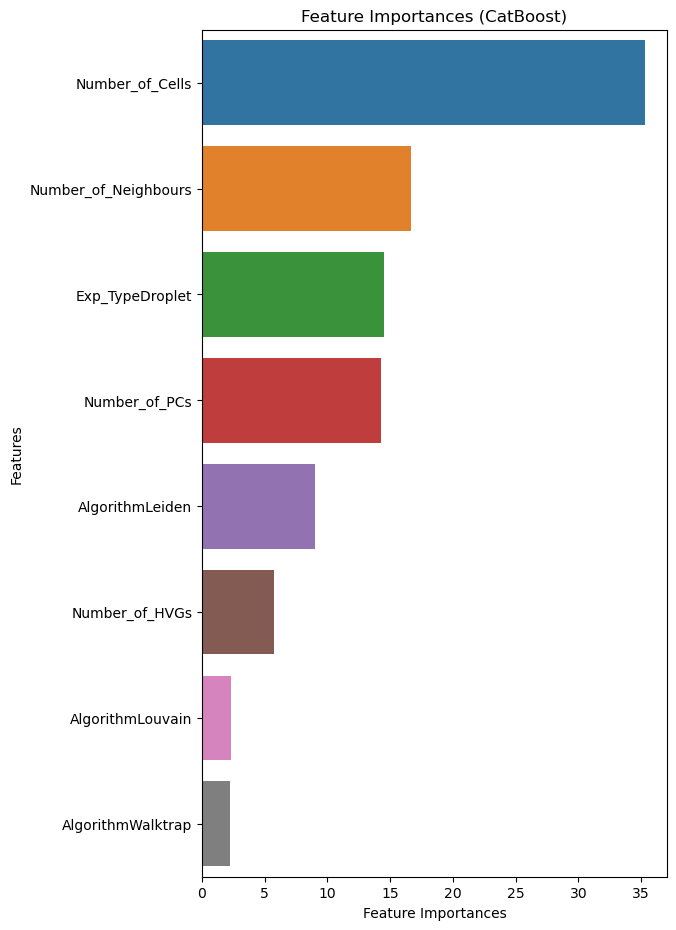

In [26]:
import seaborn as sns

feature_imp = pd.Series(catb_tuned.feature_importances_,
                        index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importances')
plt.ylabel('Features')
plt.title("Feature Importances (CatBoost)")
plt.show()

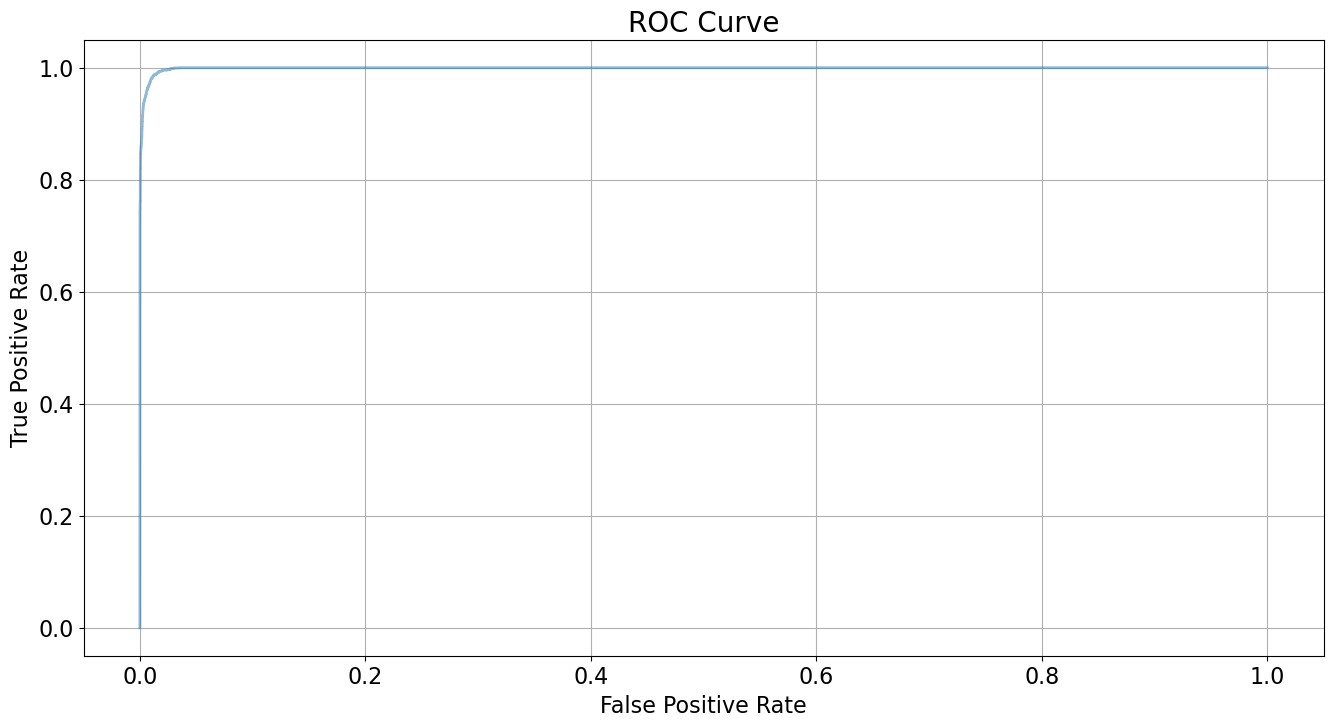

In [27]:
from catboost.utils import get_roc_curve
catboost_pool = Pool(X_train, y_train)
(fpr, tpr, thresholds) = get_roc_curve(catb_tuned, catboost_pool, plot=True)

In [28]:
print(fpr)
print(tpr)

[0.         0.         0.         ... 0.99983429 0.99991714 1.        ]
[0.00000000e+00 7.19165768e-04 1.07874865e-03 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


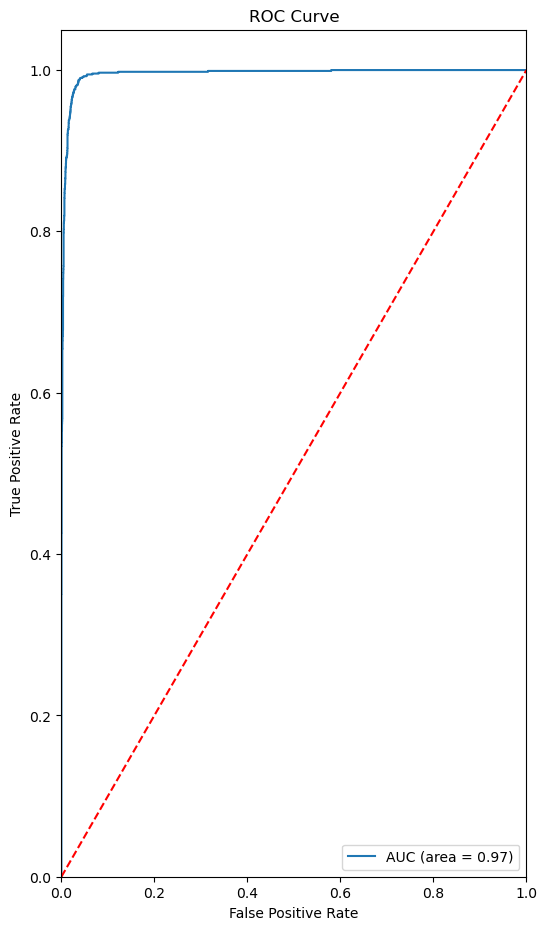

In [29]:
logit_roc_auc = roc_auc_score(y_test, catb_tuned.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, catb_tuned.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()